In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from ffm import FFMClicksPredictor
import numpy as np

Весь код для этой домашки находится в файле ffm.py

Конвертация csv в ffm делается скриптами с гитхаба (которые повторяют обработку с того самого соревнования kaggle): github.com/SongDark/libffm_converter

Я немного поменял код под задачу, так что заливаю репозиторий вместе с домашкой

Перед конвертацией я разделил данные на трейн и валидацию (последний день): `python3 split_csv.py`

Комадны для запуска конвертация выглядят так: (да, второй питон :D)
```
sudo python2 libffm_parallelizer.py libffm_converter.py /opt/downloads/ml/recsys/data_train.csv /opt/downloads/ml/recsys/data_train.ffm -n 8
sudo python2 libffm_parallelizer.py libffm_converter.py /opt/downloads/ml/recsys/data_val.csv /opt/downloads/ml/recsys/data_val.ffm -n 8
```

Есть ещё _convert_to_ffm с другого гитхаба, лежит в utils.py, но он однопоточный и я в итоге отказался от него

Запустим перебор разных k (размерностей эмбеддингов). Я хотел запустить grid search, но мой компьютер его не потянул, так что я отказался от этой идеи :(

In [3]:
!python3 ffm.py

All 1 baseline: acc 0.035398205148197866 log loss 33.3169369956324, auc 0.5
All 0 baseline: acc 0.9646017948518021 log loss 1.2226106923947828, auc 0.5
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
----------------------------------------------------------------------------------------------

[------------] xLearn uses 8 threads for training task.
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (/opt/downloads/ml/recsys/data_train.ffm.bin) found. Skip converting text to binary.
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (/opt/downloads/ml/recsys/data

[------------] Loss function: cross-entropy
[------------] Score function: ffm
[------------] Number of Feature: 9999997
[------------] Number of K: 8
[------------] Number of field: 5
[------------] Time cost for loading model: 1.40 (sec)
[ ACTION     ] Read Problem ...
[------------] First check if the text file has been already converted to binary format.
[------------] Binary file (/opt/downloads/ml/recsys/data_val.ffm.bin) found. Skip converting text to binary.
[------------] Time cost for reading problem: 0.49 (sec)
[ ACTION     ] Start to predict ...
[------------] The test loss is: 0.124384
[ ACTION     ] Clear the xLearn environment ...
[------------] Total time cost: 2.94 (sec)
FFM lr 0.1 l2 0.0002 k 8 model: acc 0.965599456640698 log loss 0.12437600808863317, auc 0.8186872867785262
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_

[   50%      ]    10            0.073508            0.124923            0.817707                4.92
[   55%      ]    11            0.070546            0.125431            0.816825                5.01
[   60%      ]    12            0.067768            0.126025            0.815651                5.18
[ ACTION     ] Early-stopping at epoch 9, best AUC: 0.818302
[ ACTION     ] Start to save model ...
[------------] Model file: /opt/downloads/ml/recsys/ffm/model.out
[------------] Time cost for saving model: 1.97 (sec)
[ ACTION     ] Finish training
[ ACTION     ] Clear the xLearn environment ...
[------------] Total time cost: 78.71 (sec)
----------------------------------------------------------------------------------------------
           _
          | |
     __  _| |     ___  __ _ _ __ _ __
     \ \/ / |    / _ \/ _` | '__| '_ \ 
      >  <| |___|  __/ (_| | |  | | | |
     /_/\_\_____/\___|\__,_|_|  |_| |_|

        xLearn   -- 0.40 Version --
-------------------------------------

Получили log loss лучшей модели 0.124 (против 0.135 у линейной) и auc 0.819 (против 0.771 у линейной)
Превзошли как бейзлайны с всему 0 и 1, так и линейную модель

Притом на самом деле, при k=10 и при k=2 результаты отличаются незначительно: лучший AUC 0.819 против 0.818, так что можно использовать и меньшую модель, которая к тому же в несколько раз меньше. Кстати, из-за Hogwild! и lock-free обучения результаты недетерменированны и для k=10 не воспроизвелись, так что итоговоая модель имеет качество 0.818, и без разницы, какой k использовать

In [13]:
with open('/opt/downloads/ml/recsys/ffm/reses_dict', 'r') as f:
    reses = eval(f.read())

In [14]:
reses

{10: (0.9656036840211595, 0.1243133952515984, 0.8190759889591593),
 8: (0.965599456640698, 0.12437600808863317, 0.8186872867785262),
 4: (0.9656088508195012, 0.12450785405510574, 0.8184566557432239),
 2: (0.9655712741042886, 0.12452355037015102, 0.8183023845913405)}

In [15]:
y_test_lin, y_pred_lin = [], []
with open('/opt/downloads/ml/recsys/ffm/linear_y_test', 'r') as f1, open('/opt/downloads/ml/recsys/ffm/linear_y_pred', 'r') as f2:
    for i in f1:
        y_test_lin.append(float(i))
    for i in f2:
        y_pred_lin.append(float(i))
y_test_lin = np.array(y_test_lin)
y_pred_lin = np.array(y_pred_lin)

In [16]:
from sklearn.metrics import roc_curve, auc as aucc

fpr_l, tpr_l, _ = roc_curve(y_test_lin, y_pred_lin)
roc_auc_l = auc(fpr_l, tpr_l)

In [17]:
y_last = FFMClicksPredictor().get_y("/opt/downloads/ml/recsys/data_val.ffm", lambda l: int(l[0]))
y_pred = FFMClicksPredictor().get_y("/opt/downloads/ml/recsys/ffm/output.txt", lambda l: float(l))

In [18]:
fpr, tpr, _ = roc_curve(y_last, y_pred)
roc_auc = auc(fpr, tpr)

Построим ROC кривую и сравним FFM и линейную модели. Очевидно, что FFM лучше линейной

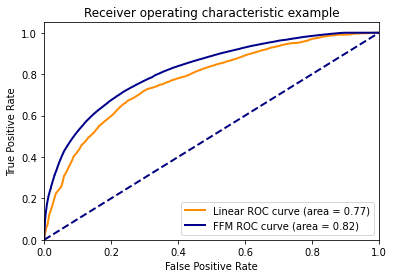

In [19]:
plt.figure()
lw = 2
plt.plot(
    fpr_l,
    tpr_l,
    color="darkorange",
    lw=lw,
    label="Linear ROC curve (area = %0.2f)" % roc_auc_l,
)
plt.plot(
    fpr,
    tpr,
    color="darkblue",
    lw=lw,
    label="FFM ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [20]:
reses.values()

dict_values([(0.9656036840211595, 0.1243133952515984, 0.8190759889591593), (0.965599456640698, 0.12437600808863317, 0.8186872867785262), (0.9656088508195012, 0.12450785405510574, 0.8184566557432239), (0.9655712741042886, 0.12452355037015102, 0.8183023845913405)])

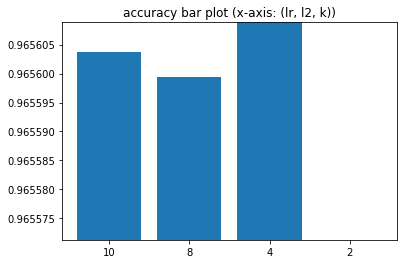

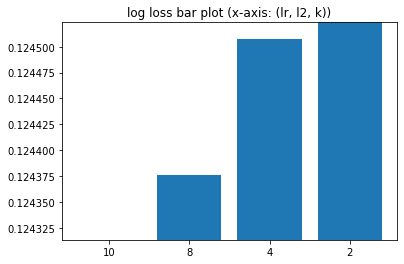

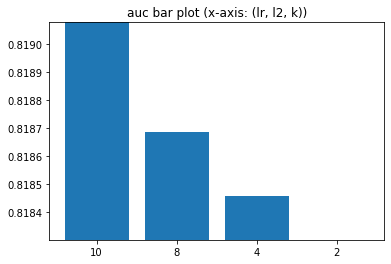

In [21]:
for ind,name in [(0, 'accuracy'), (1, 'log loss'), (2, 'auc')]:
    plt.title(f'{name} bar plot (x-axis: (lr, l2, k))')
    vals = [i[ind] for i in reses.values()]
    plt.bar([str(i) for i in reses.keys()], vals)
    plt.ylim(min(vals), max(vals))
    plt.show()